### Importy

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import shap
from scripts.train_utilities import *
from scripts.essentials import *
from scripts.plots import *

In [4]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [57]:
train_set = pd.read_csv('train_set_full.csv')
test_set = pd.read_csv('test_set_full.csv')
val_set = pd.read_csv('val_set_full.csv')

In [56]:
prefix = "BTC-USD"

### Zmienne

Newsy

In [58]:
train_set.columns

Index(['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', '^GSPC_Close',
       'EURUSD=X_Close', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low',
       'BTC-USD_Close', 'mean_future', 'mean_influential', 'mean_trustworthy',
       'mean_clickbait', 'norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14',
       'vwap_14', 'norm_roc_14', 'log_return_1', 'log_return_7',
       'log_return_14', 'log_return_28', 'log_return_gspc_1',
       'log_return_gspc_7', 'log_return_gspc_14', 'log_return_gspc_28',
       'target_1', 'target_7', 'target_14', 'target_28', 'minmax_^GSPC_Volume',
       'minmax_BTC-USD_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressu

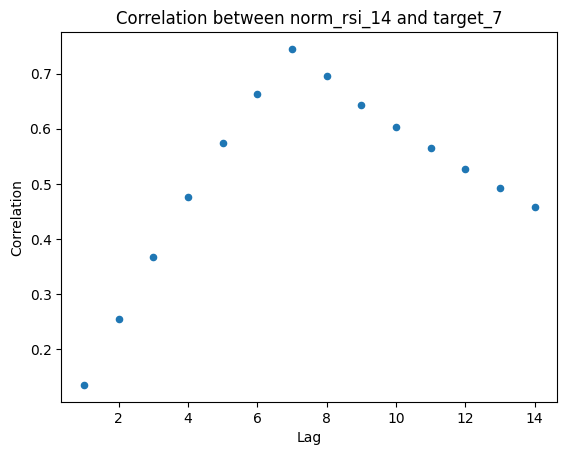

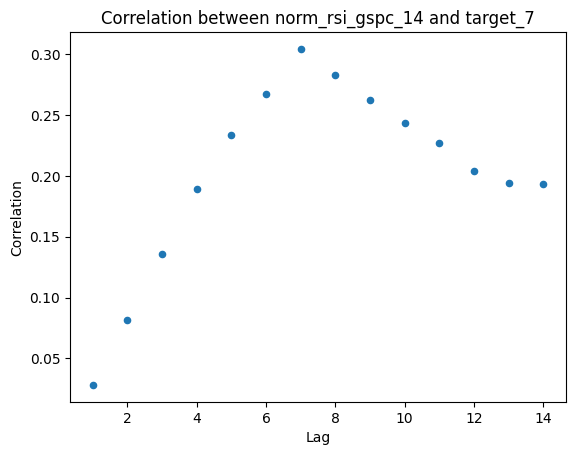

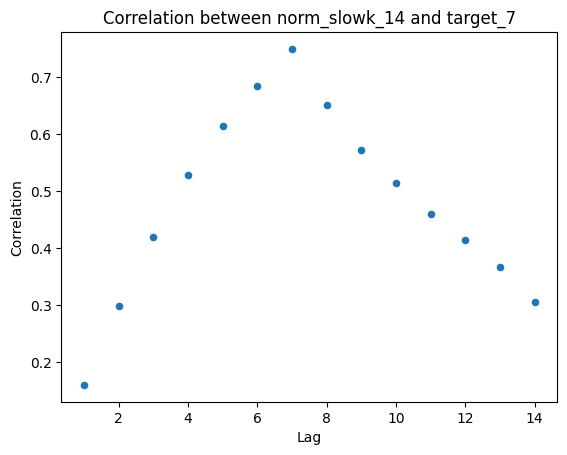

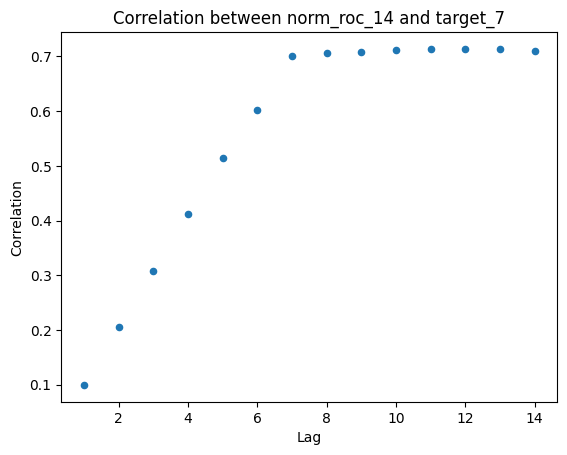

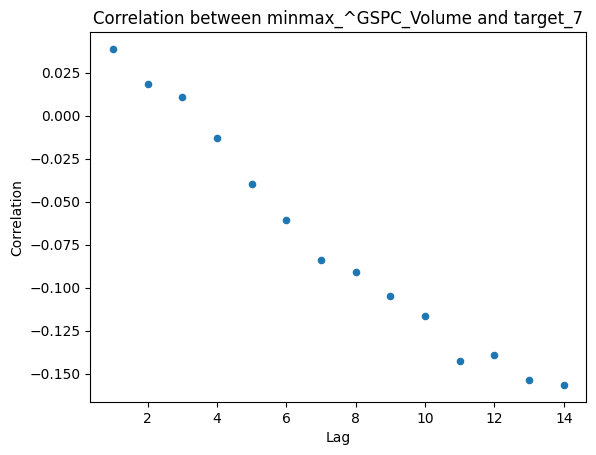

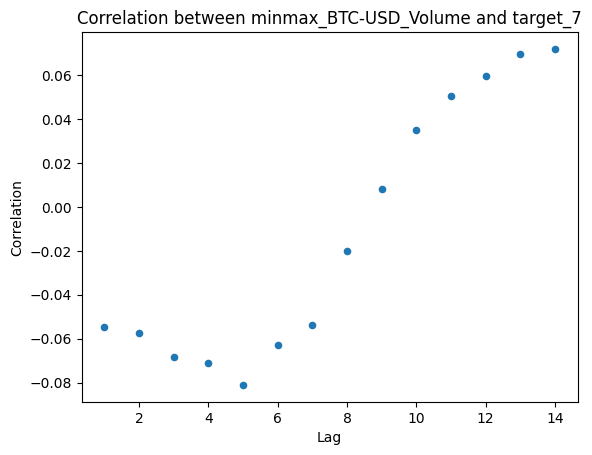

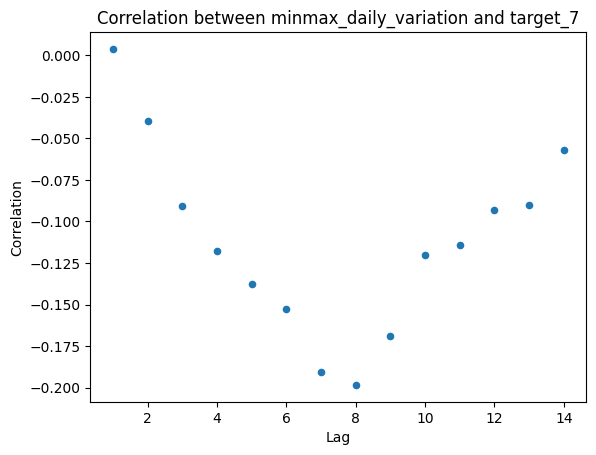

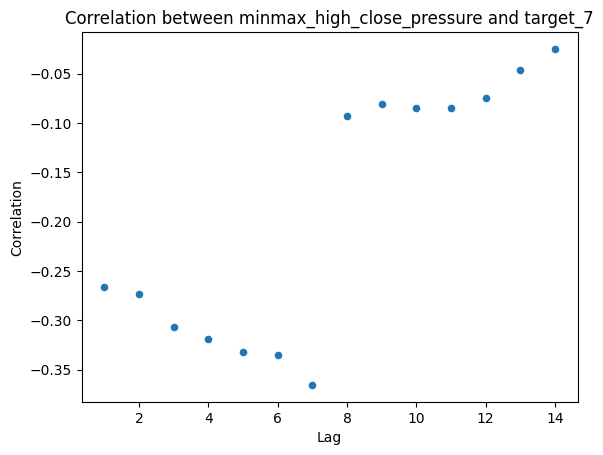

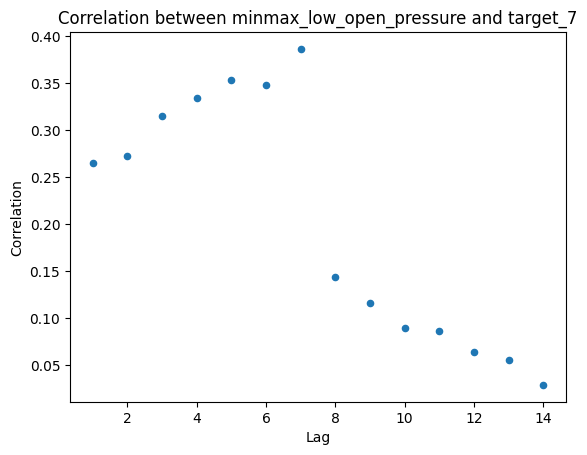

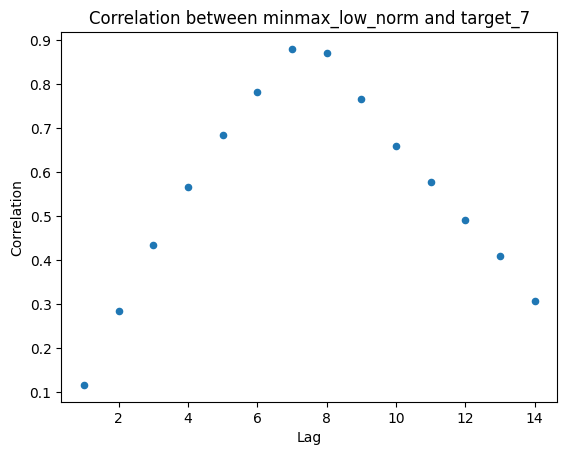

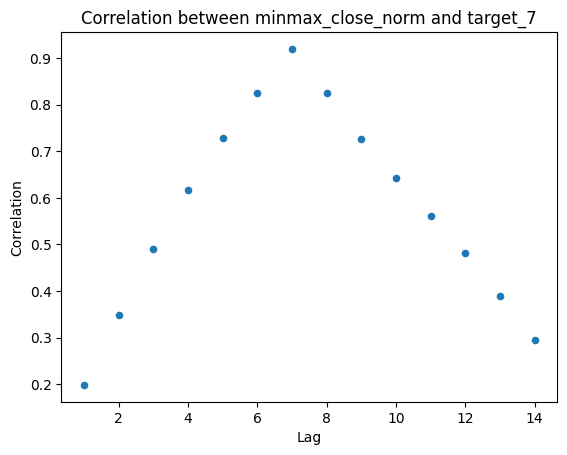

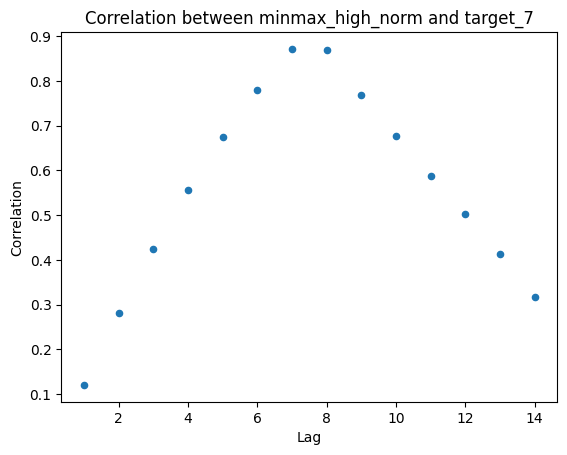

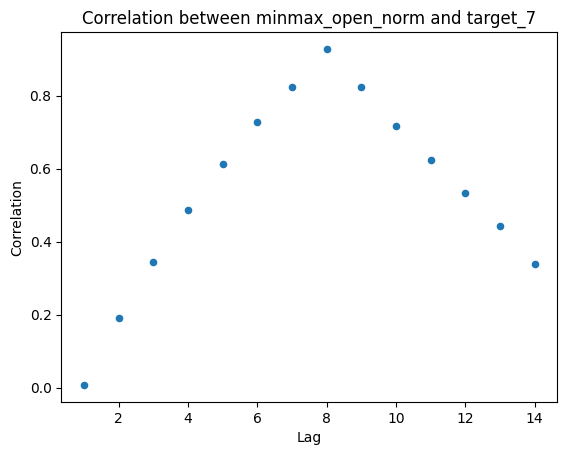

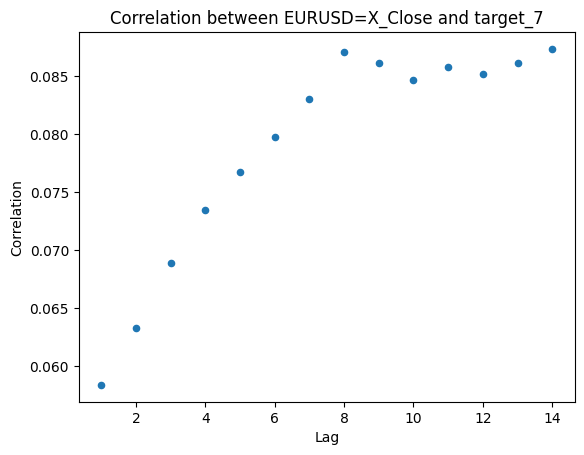

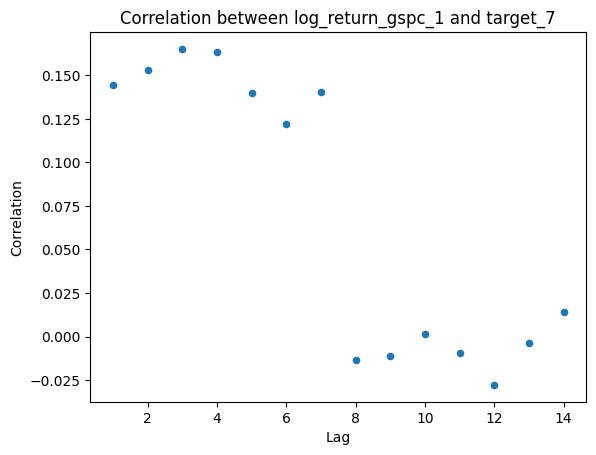

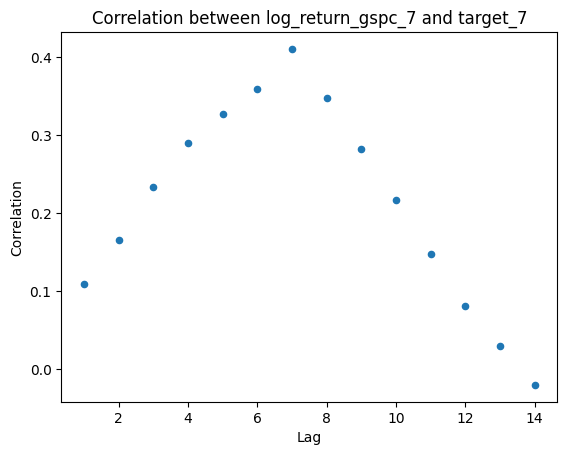

In [59]:
plot_lagged_correlations(train_set[['norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'norm_roc_14',
        'minmax_^GSPC_Volume', 'minmax_BTC-USD_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressure', 'minmax_low_open_pressure',
       'minmax_low_norm', 'minmax_close_norm', 'minmax_high_norm',
       'minmax_open_norm', 'EURUSD=X_Close', 'log_return_gspc_1' ,'log_return_gspc_7','target_7']], 'target_7')

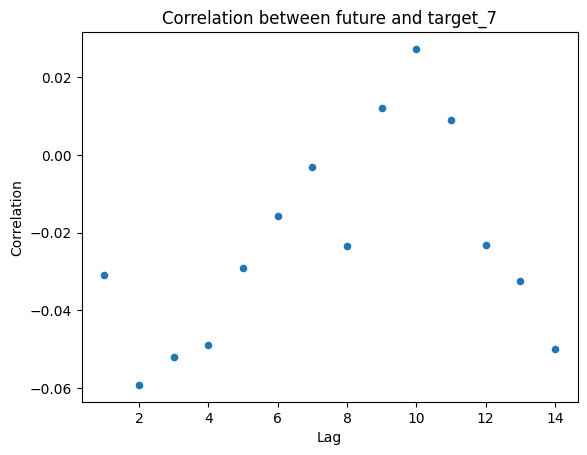

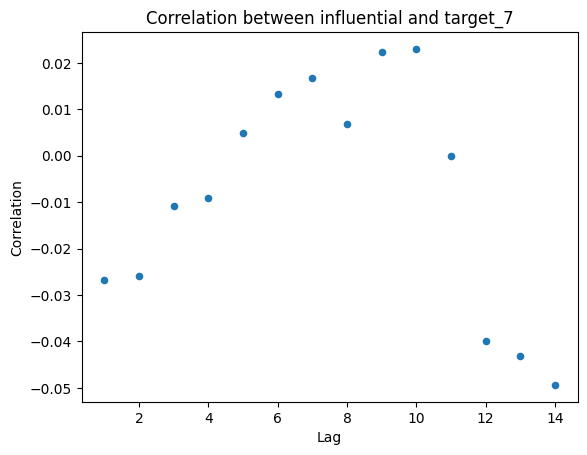

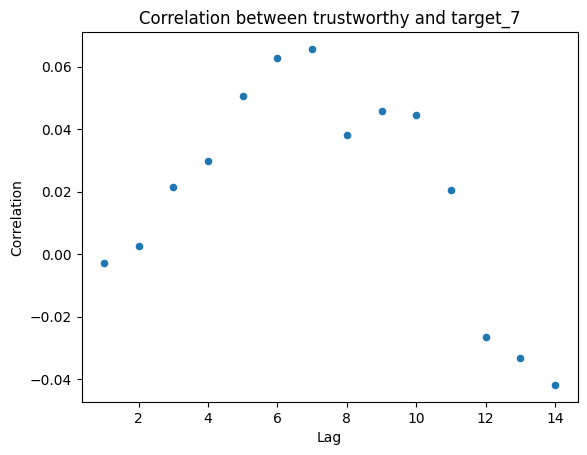

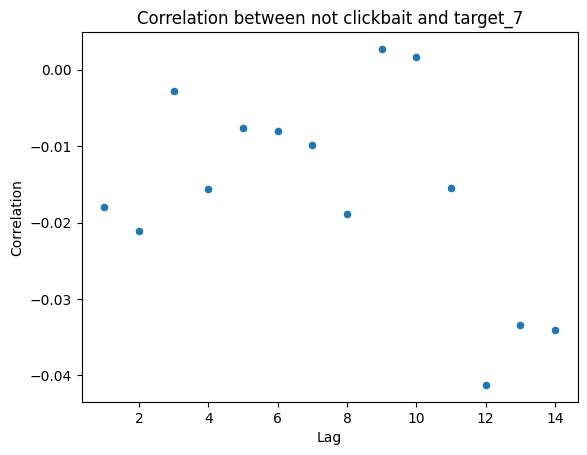

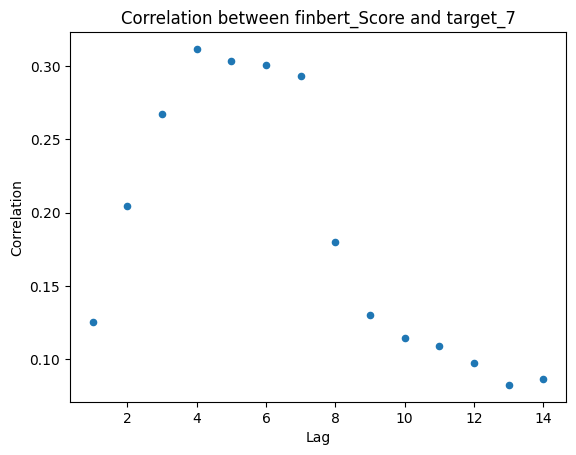

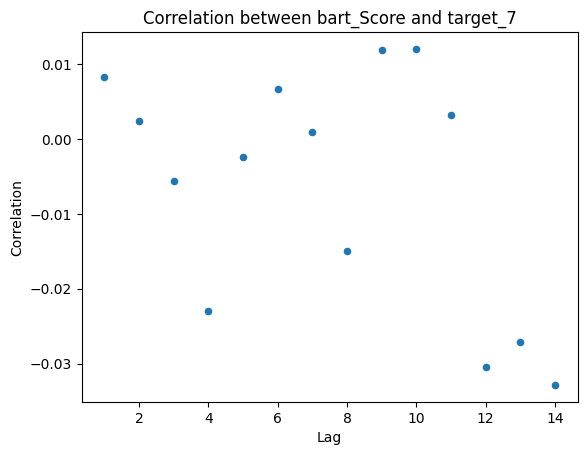

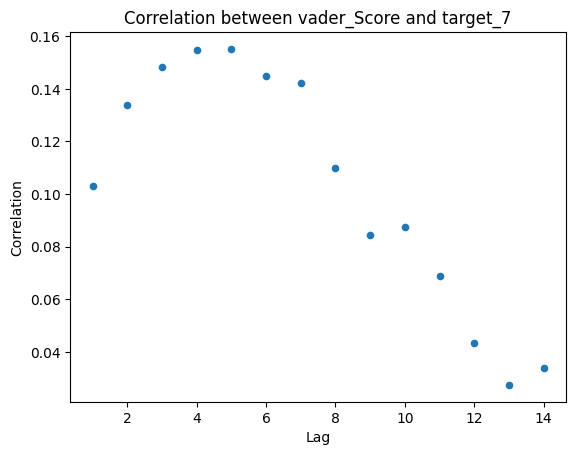

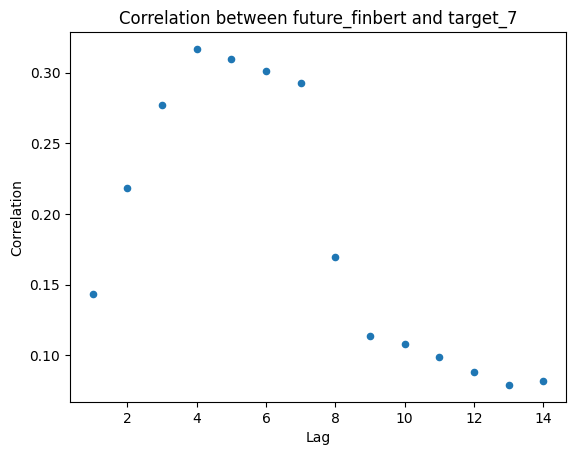

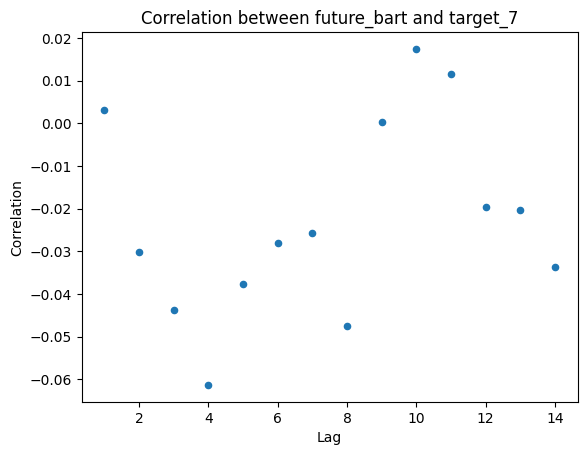

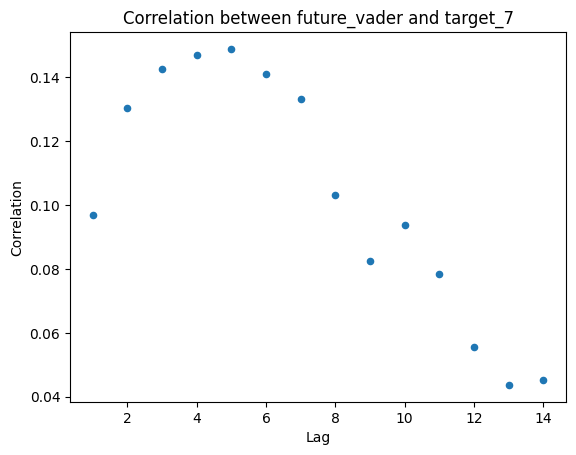

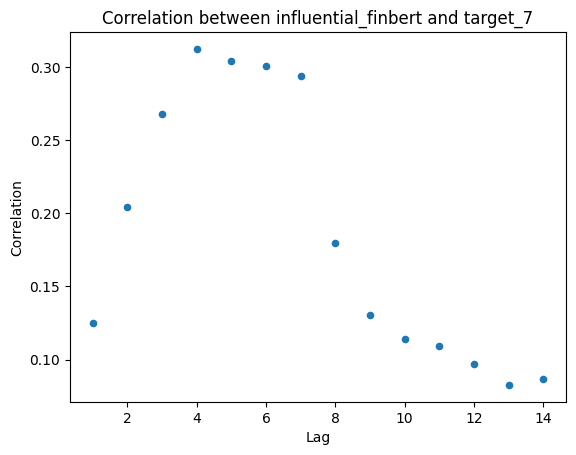

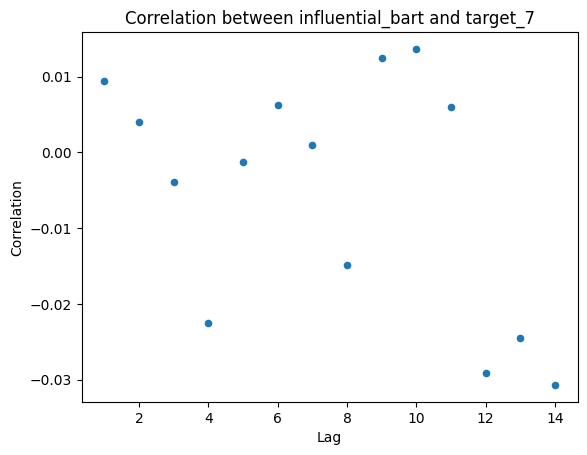

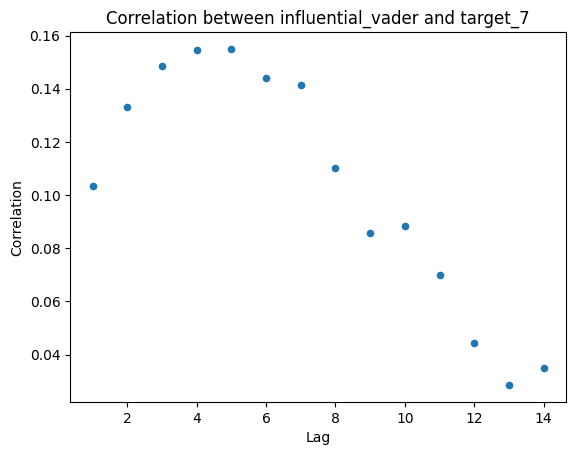

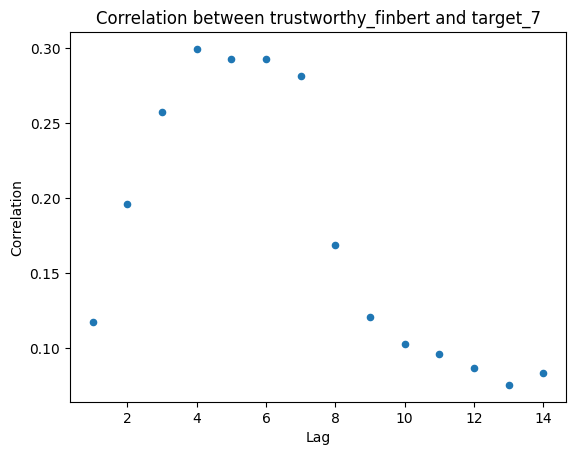

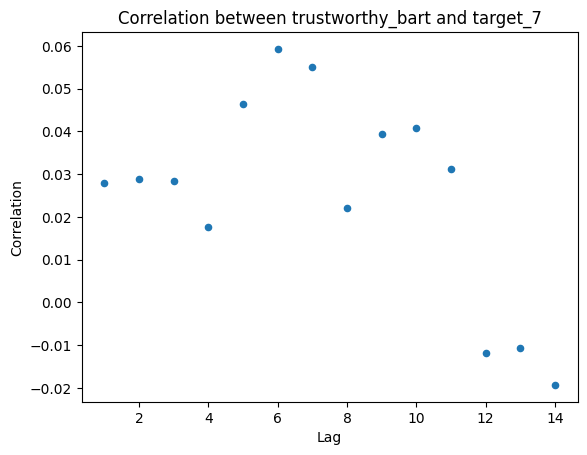

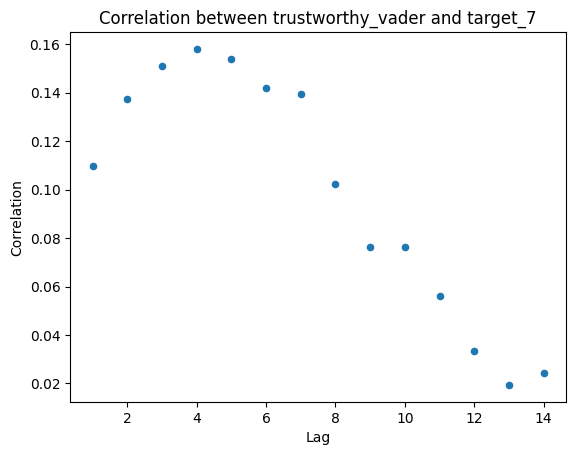

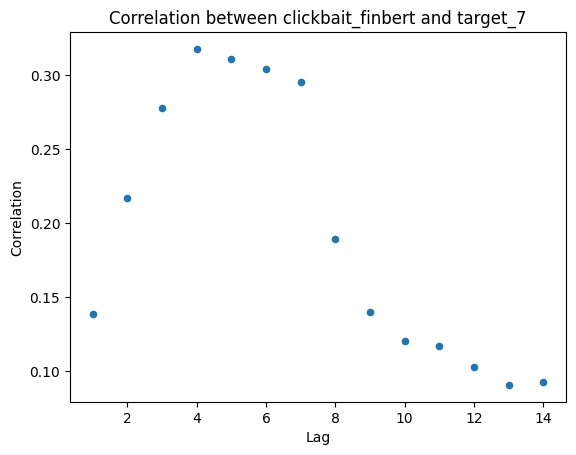

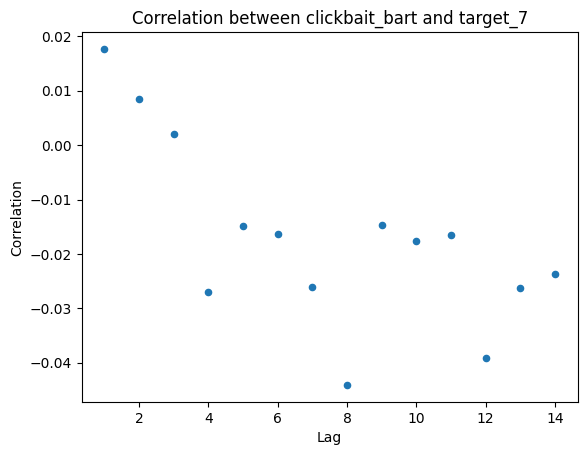

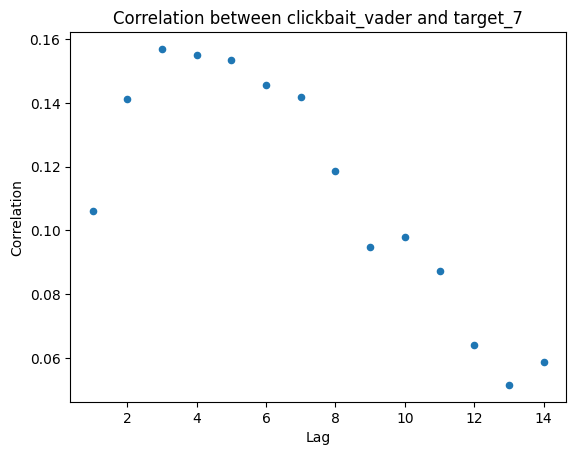

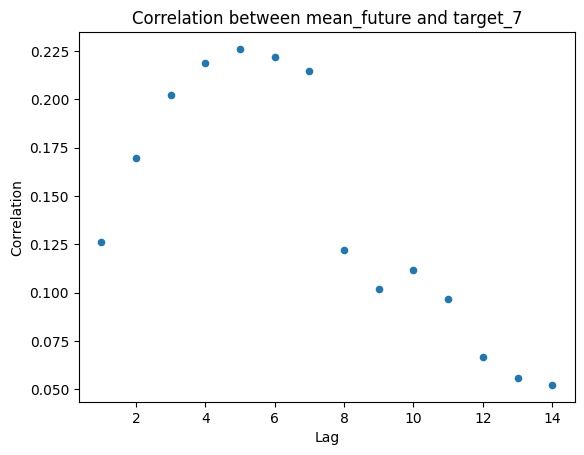

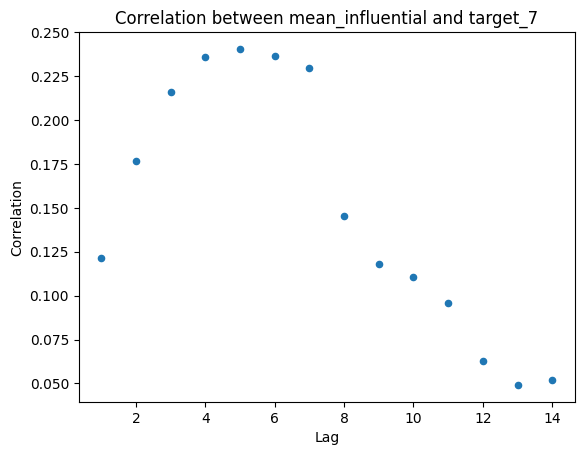

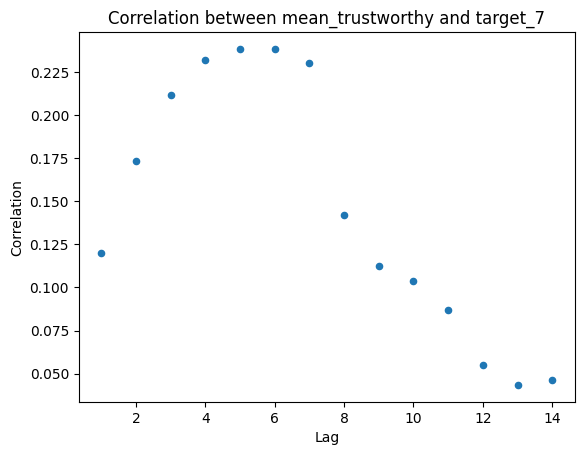

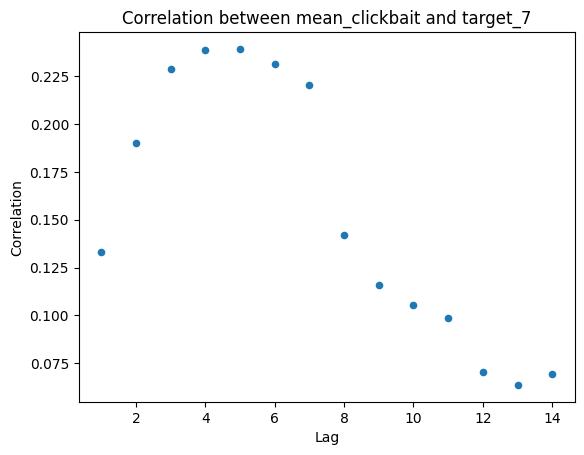

In [60]:
plot_lagged_correlations(train_set[['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader','mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait','target_7']], 'target_7')

### Shap dla prostych LSTM - szukanie globalnej wagi kolumn

In [67]:
cols = ['finbert_Score', 'bart_Score', 'vader_Score',
        'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
        'norm_rsi_14', 'norm_rsi_gspc_14',
        'norm_slowk_14', 'norm_roc_14',
        'minmax_BTC-USD_Volume','log_return_7','log_return_1','EURUSD=X_Close',
        'minmax_daily_variation', 'minmax_high_close_pressure',
        'minmax_low_open_pressure',
        'minmax_low_norm', 'minmax_close_norm',
        'minmax_high_norm', 'minmax_open_norm']

u = create_unique_subsets(cols, subset_size=5, min_diff=3)

In [69]:
shift_ = 5
window_size = 14
target_cols = ['target_7']
y_base_val = val_set[target_cols[0]].shift(shift_)[window_size:].values
y_base_train = train_set[target_cols[0]].shift(shift_)[window_size:].values
y_base0_val = [0 for i in range((val_set.shape[0]-window_size))]
y_base0_train = [0 for i in range((train_set.shape[0]-window_size))]

In [70]:
len(u)

97

In [ ]:
df = run_multiple_models(train_set,val_set,u,n_epochs=200, target = target_cols, window_size=window_size)

In [38]:
top_10_df = df.nsmallest(10, 'mse_val')

In [40]:
# Agregacja SHAP dla najlepszych modeli jako średnia z okien czasowych
column_importance_sum_count = {}

for index, row in top_10_df.iterrows():
    shap_values = row['aggregated_shap']
    cols = row['cols_used']
    mean_shap = np.mean(shap_values, axis=0)

    for col, value in zip(cols, mean_shap):
        if col in column_importance_sum_count:
            column_importance_sum_count[col]['sum'] += value
            column_importance_sum_count[col]['count'] += 1
        else:
            column_importance_sum_count[col] = {'sum': value, 'count': 1}

column_importance_mean = {col: (val['sum'] / val['count'] , val['count']) for col, val in column_importance_sum_count.items()}

sorted_column_importance_mean = dict(sorted(column_importance_mean.items(), key=lambda item: item[1], reverse=True))

sorted_column_importance_mean

{'finbert_Score': (0.008206609761904762, 6),
 'mean_influential': (0.008039172142857142, 1),
 'vader_Score': (0.0053636880952380945, 3),
 'minmax_BTC-USD_Volume': (0.005349995, 3),
 'norm_slowk_14': (0.005209961428571428, 3),
 'mean_trustworthy': (0.004307988571428572, 1),
 'bart_Score': (0.004182629285714286, 1),
 'norm_rsi_gspc_14': (0.004072536071428571, 2),
 'mean_future': (0.0038229303571428574, 2),
 'norm_rsi_14': (0.0037592661428571426, 5),
 'norm_roc_14': (0.003714747142857143, 1),
 'minmax_daily_variation': (0.003474967142857143, 3),
 'minmax_high_close_pressure': (0.003353532857142857, 1),
 'minmax_open_norm': (0.0018122385714285712, 3),
 'minmax_close_norm': (0.0016711953571428573, 2),
 'minmax_low_norm': (0.0015157137500000002, 4),
 'minmax_low_open_pressure': (0.0012262302380952382, 3),
 'log_return_1': (0.0008933747619047618, 3),
 'EURUSD=X_Close': (0.0004947295238095238, 3)}

In [41]:
# Agregacja SHAP dla najlepszych modeli jako max z okien czasowych
column_importance_sum_count = {}

for index, row in top_10_df.iterrows():
    shap_values = row['aggregated_shap']
    cols = row['cols_used']
    mean_shap = np.max(shap_values, axis=0)

    for col, value in zip(cols, mean_shap):
        if col in column_importance_sum_count:
            column_importance_sum_count[col]['sum'] += value
            column_importance_sum_count[col]['count'] += 1
        else:
            column_importance_sum_count[col] = {'sum': value, 'count': 1}

column_importance_mean = {col: (val['sum'] / val['count'] , val['count']) for col, val in column_importance_sum_count.items()}

sorted_column_importance_mean = dict(sorted(column_importance_mean.items(), key=lambda item: item[1], reverse=True))

sorted_column_importance_mean

{'mean_influential': (0.01216345, 1),
 'finbert_Score': (0.011493721666666666, 6),
 'minmax_BTC-USD_Volume': (0.010505613333333332, 3),
 'vader_Score': (0.00835165, 3),
 'norm_slowk_14': (0.007888876666666668, 3),
 'bart_Score': (0.00765886, 1),
 'minmax_daily_variation': (0.007246239999999998, 3),
 'norm_rsi_14': (0.006556123999999999, 5),
 'norm_rsi_gspc_14': (0.00654906, 2),
 'mean_trustworthy': (0.00644845, 1),
 'mean_future': (0.005750485, 2),
 'norm_roc_14': (0.00477033, 1),
 'minmax_high_close_pressure': (0.00426422, 1),
 'minmax_close_norm': (0.002963355, 2),
 'minmax_open_norm': (0.0027037433333333334, 3),
 'minmax_low_open_pressure': (0.0025280800000000003, 3),
 'minmax_low_norm': (0.0022360125, 4),
 'log_return_1': (0.0015793633333333335, 3),
 'EURUSD=X_Close': (0.0007158366666666667, 3)}

### TOP 10 modeli SHAP


45


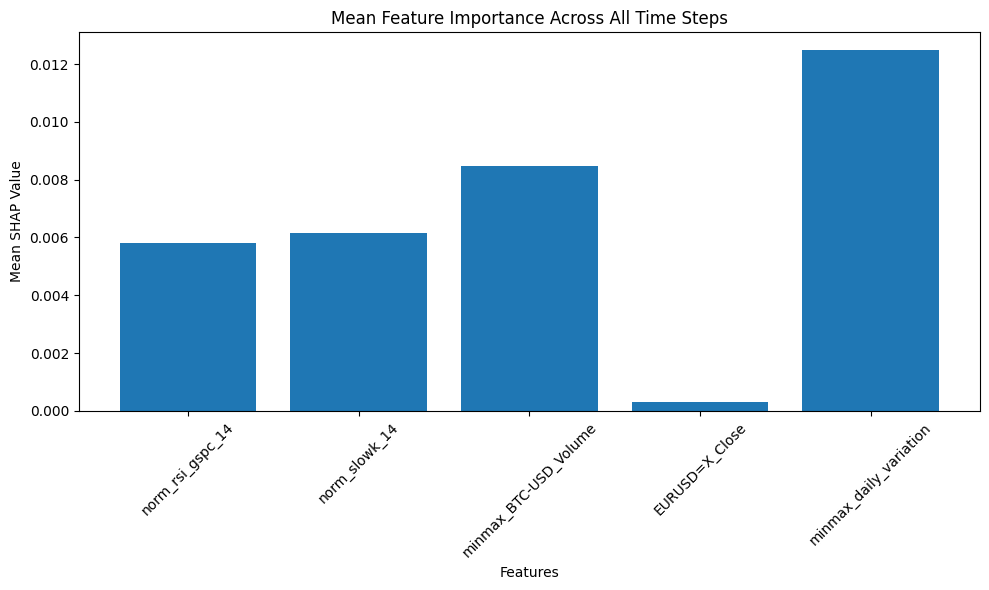

1


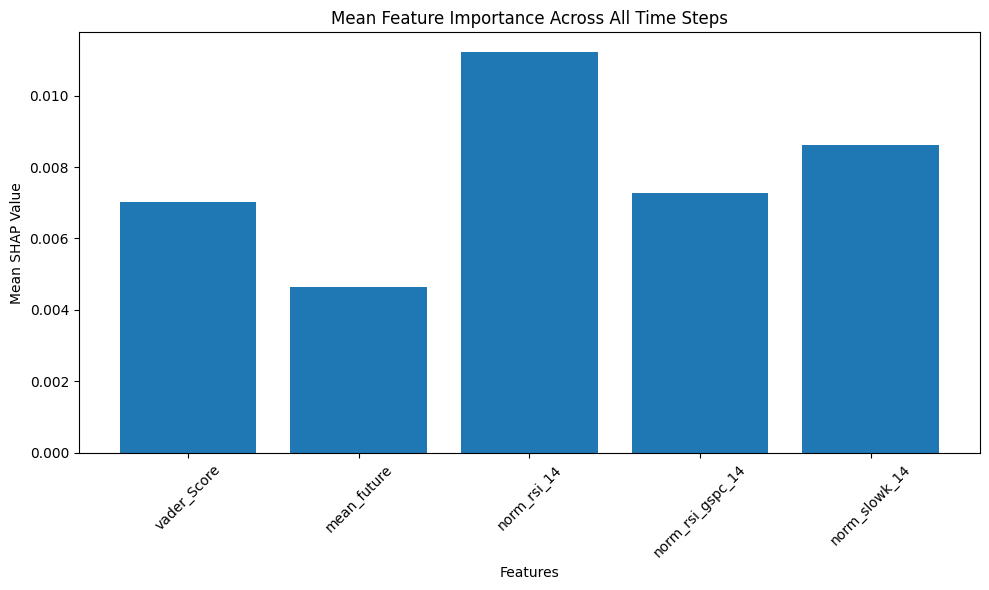

59


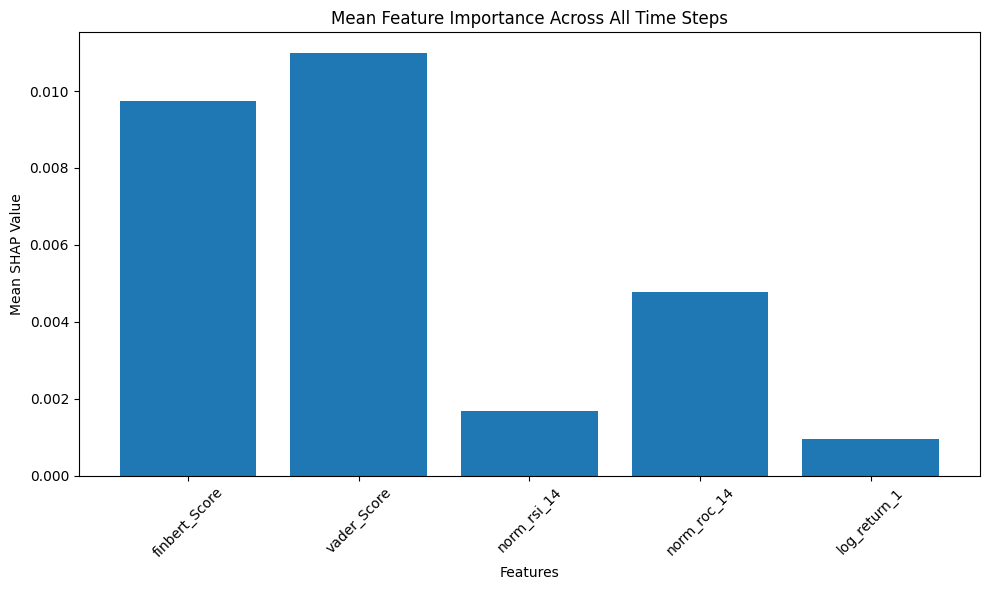

29


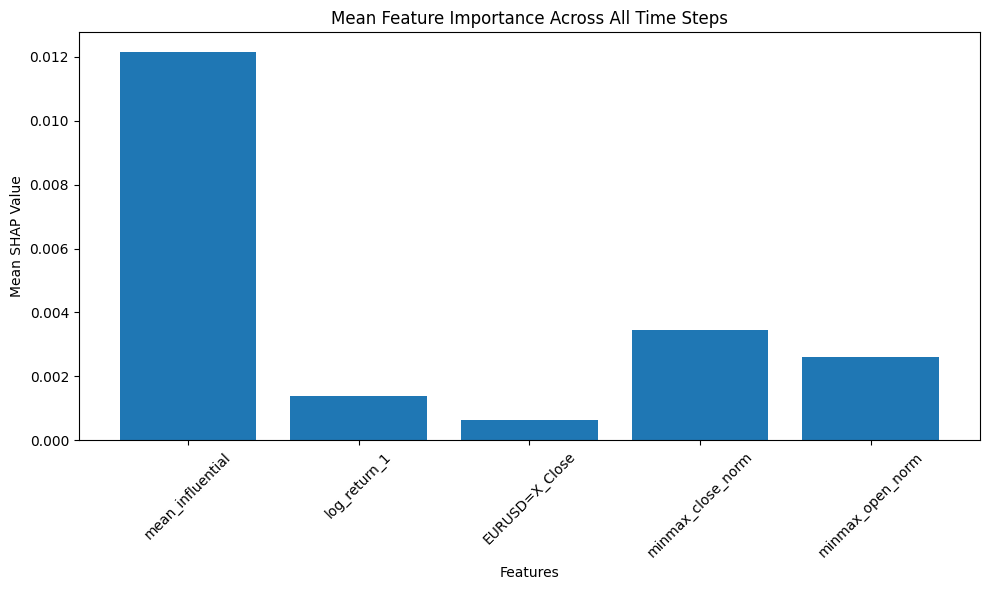

42


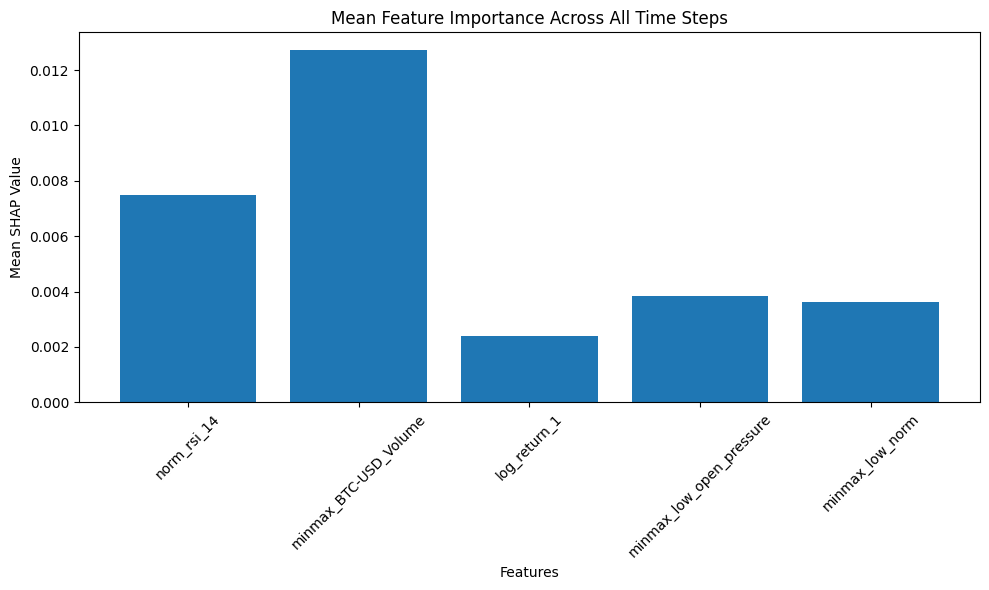

75


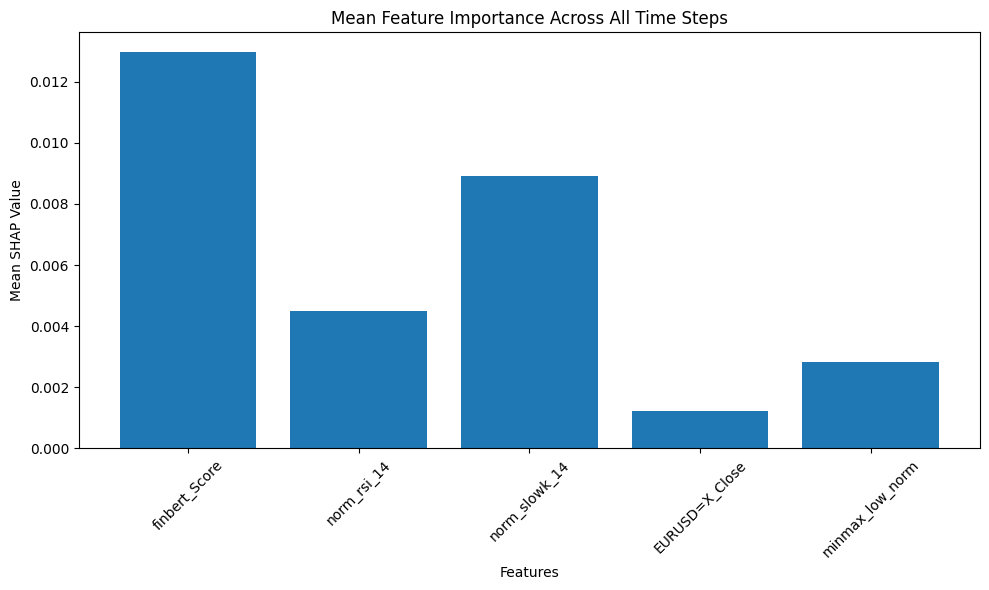

64


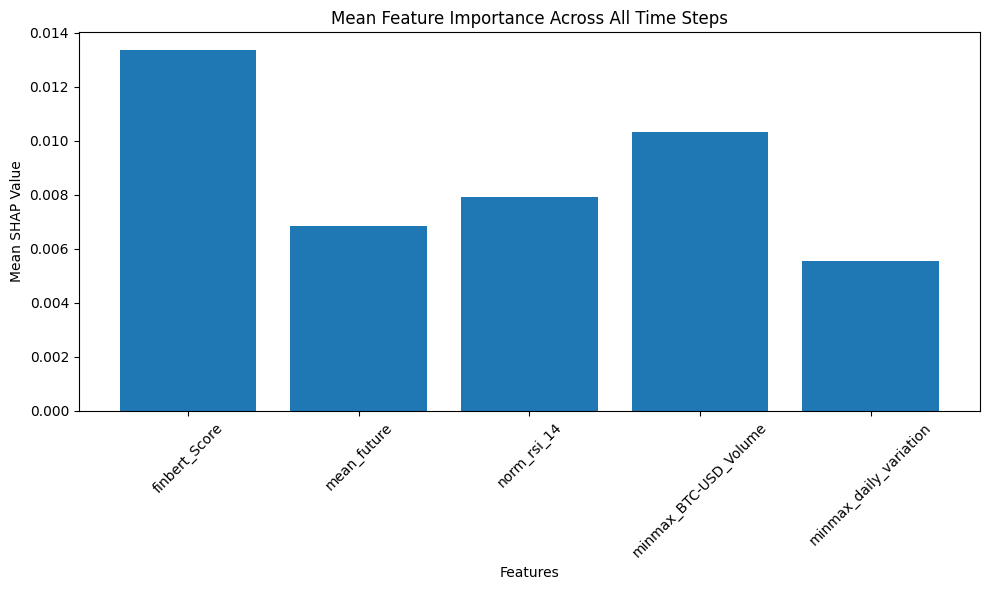

56


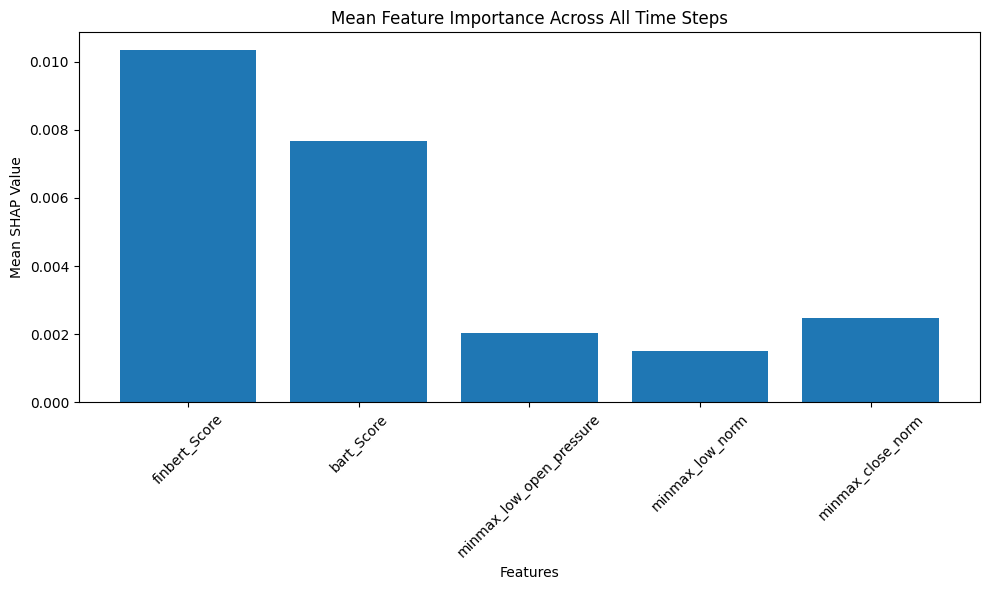

73


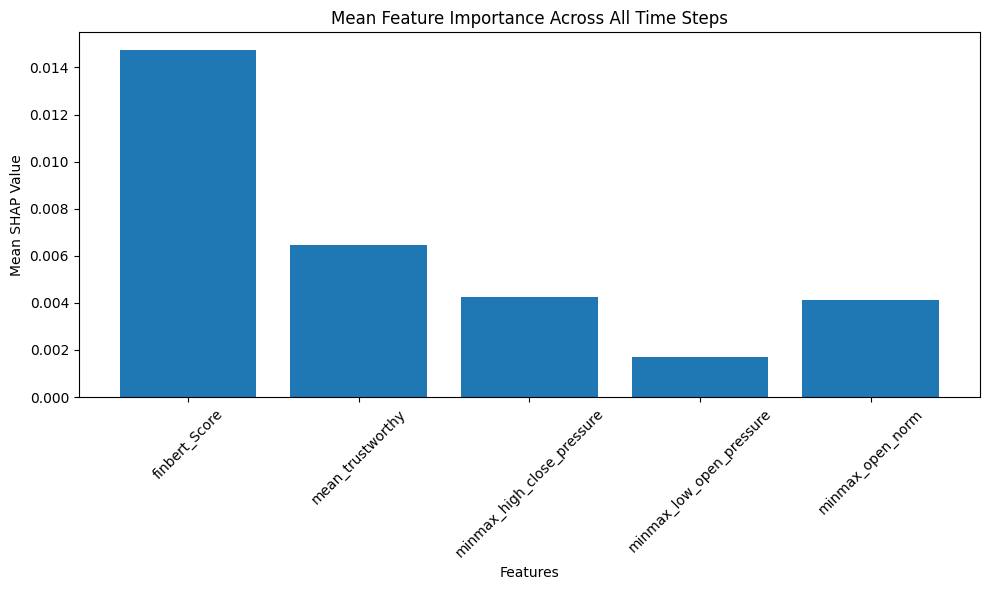

61


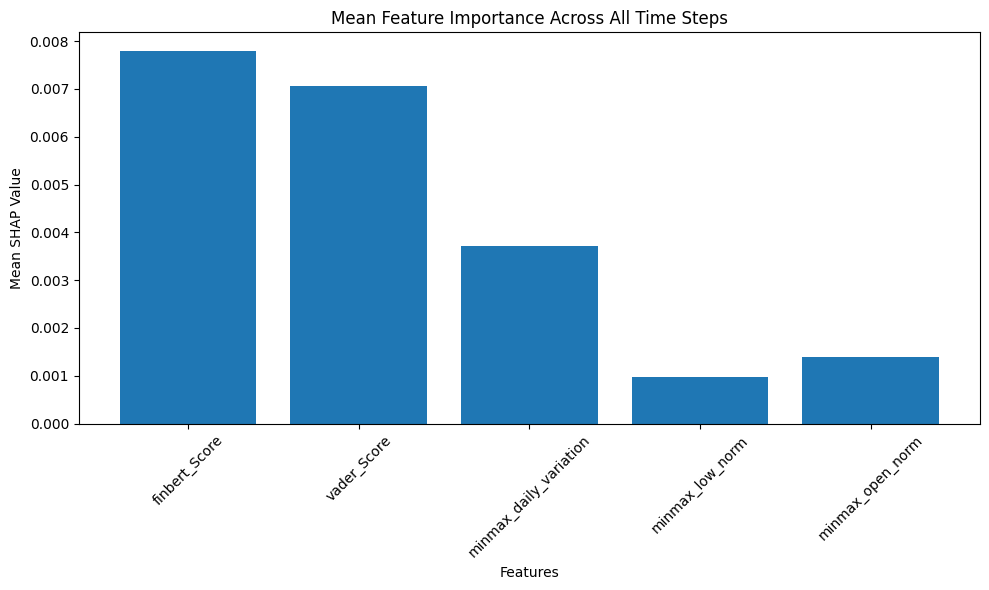

In [45]:
# Max z okien czasowych
for index, row in top_10_df.iterrows():
    print(index)
    shap_values = row['aggregated_shap']
    feature_names = row['cols_used']
    plot_mean_feature_importance(shap_values, feature_names,True)

45


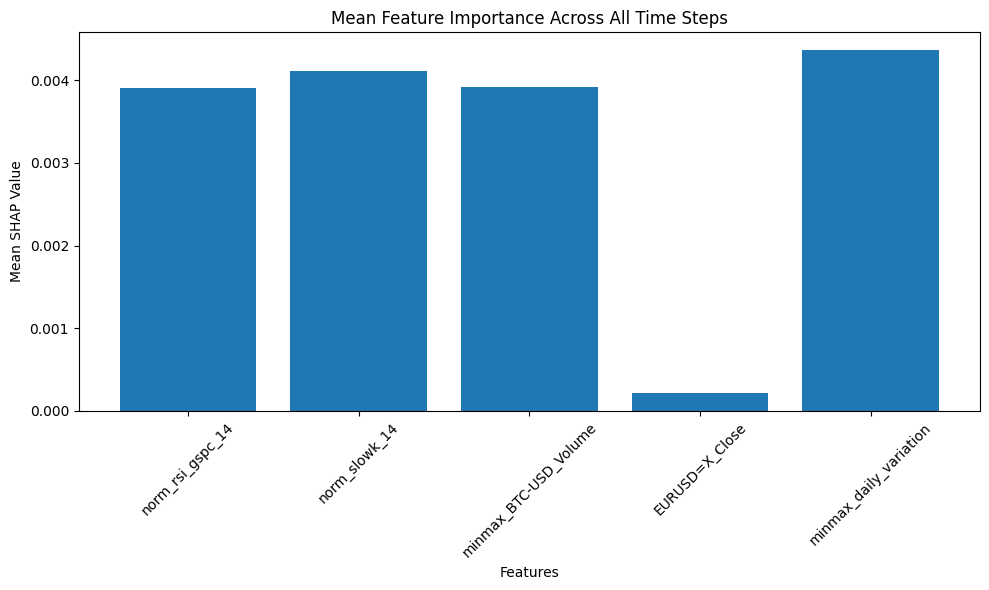

1


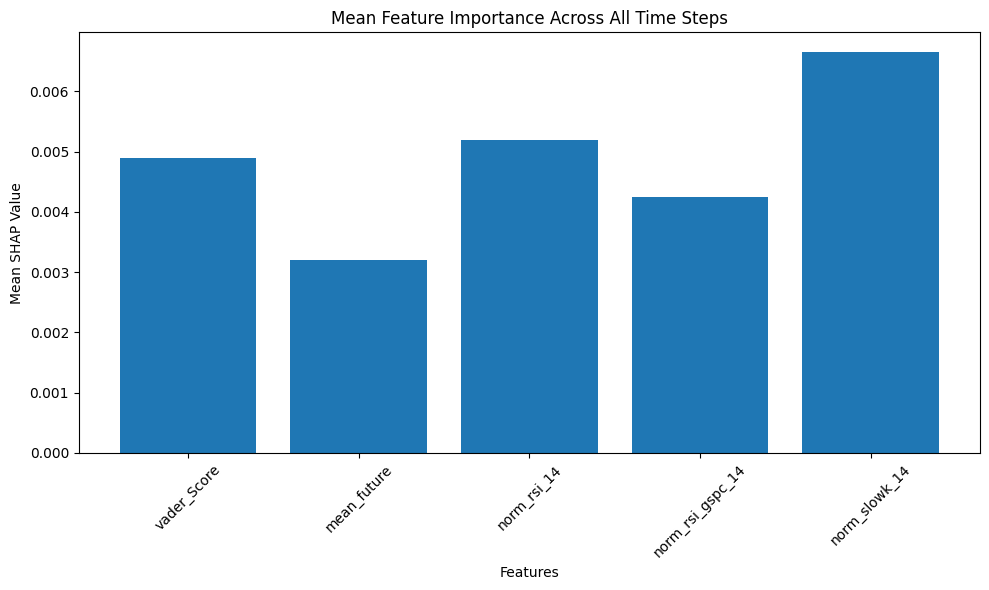

59


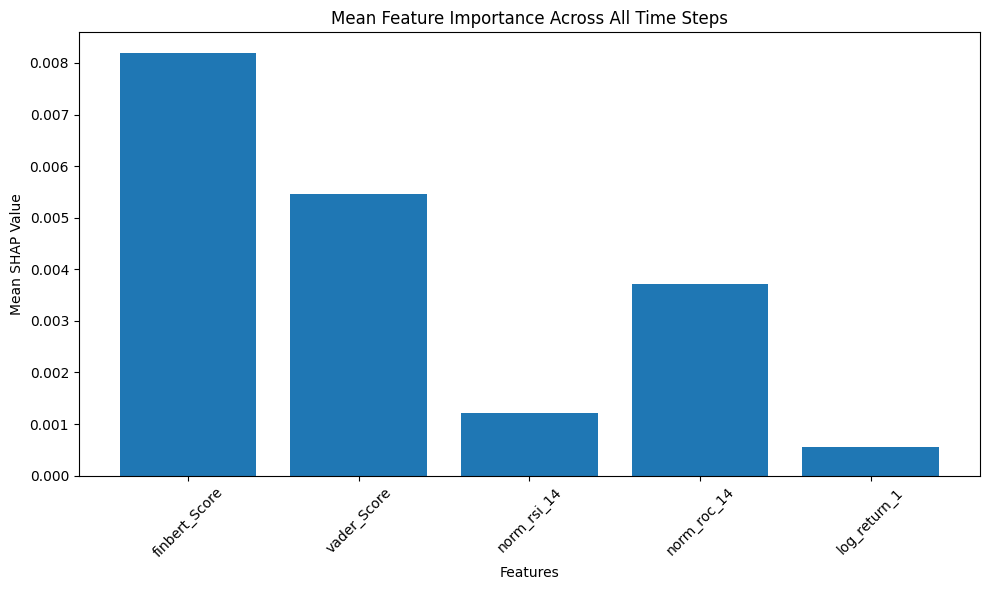

29


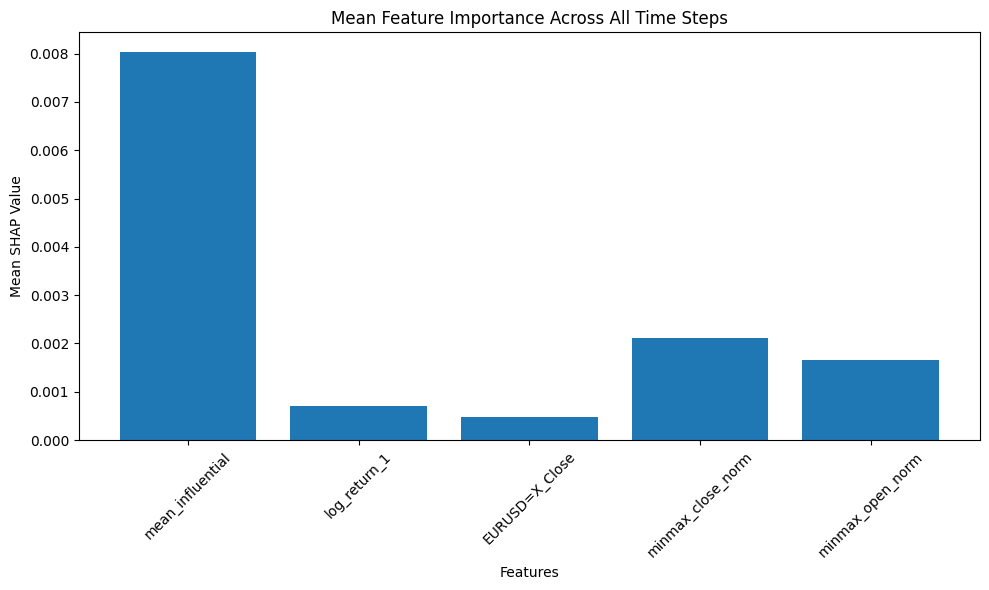

42


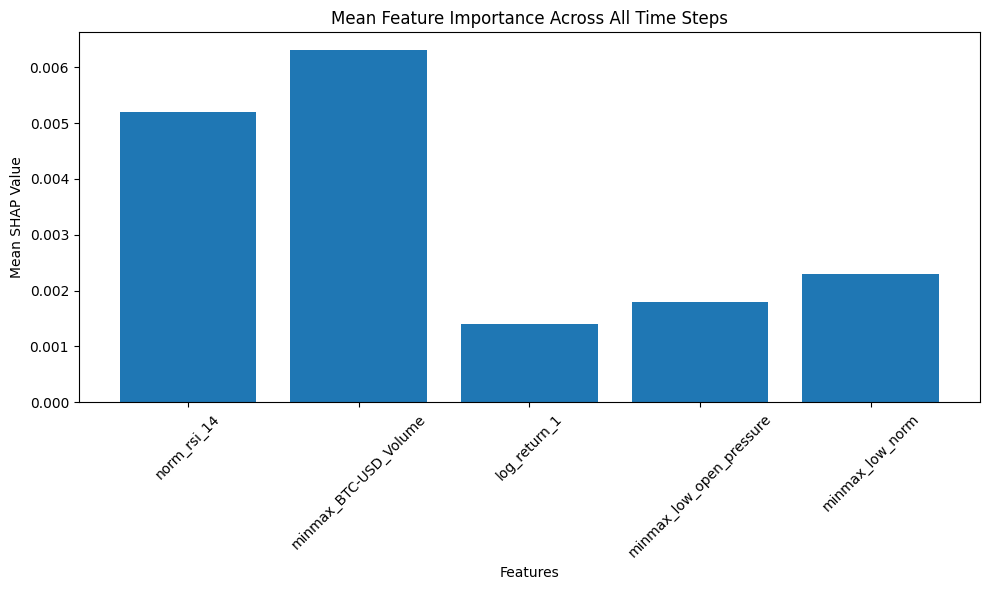

75


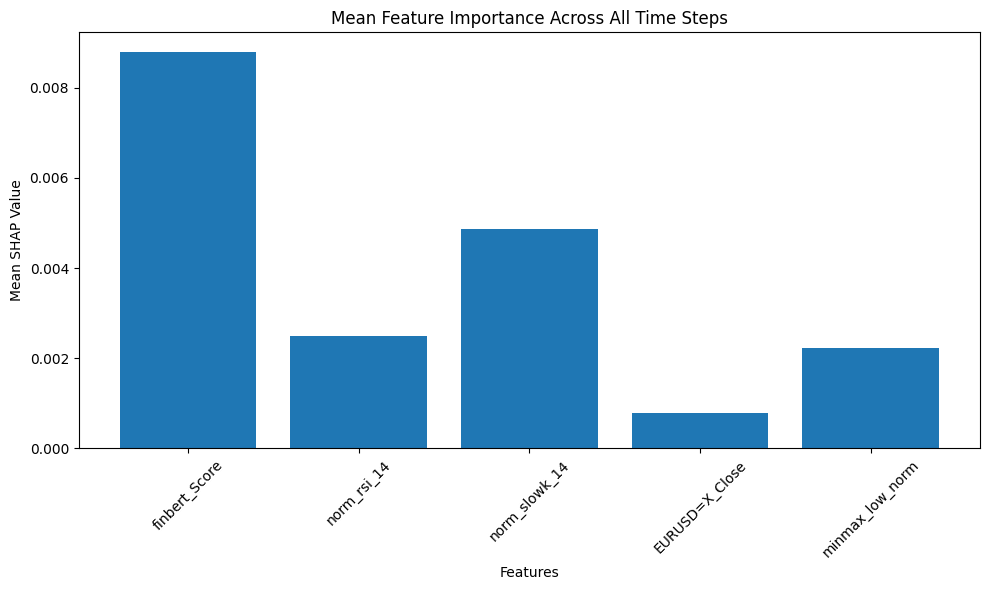

64


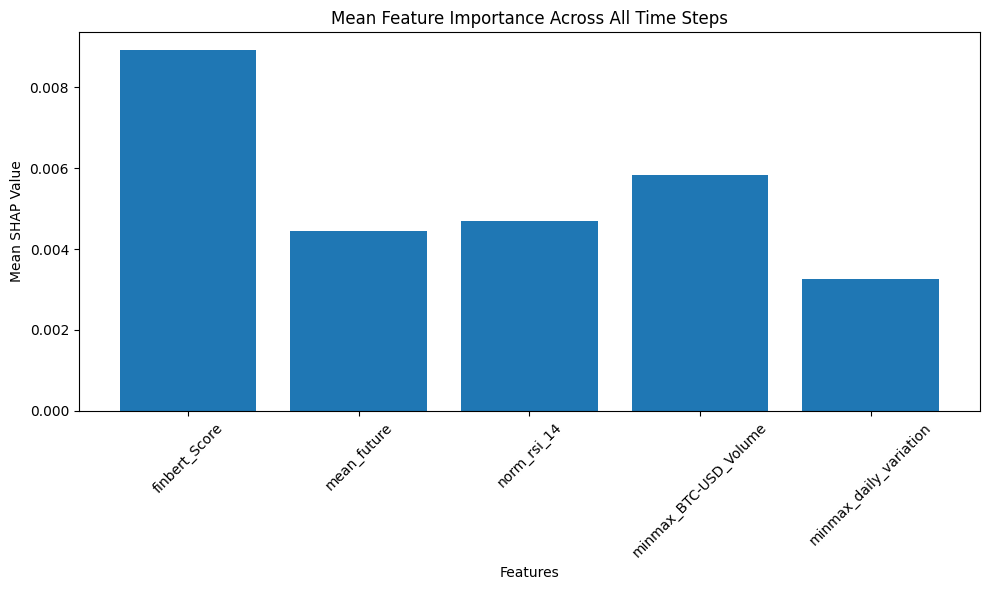

56


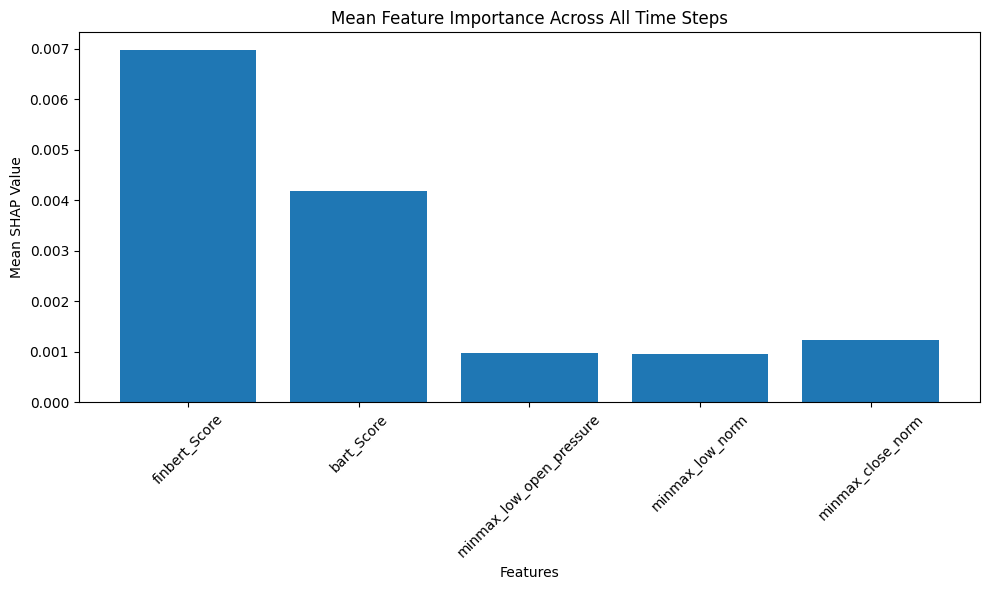

73


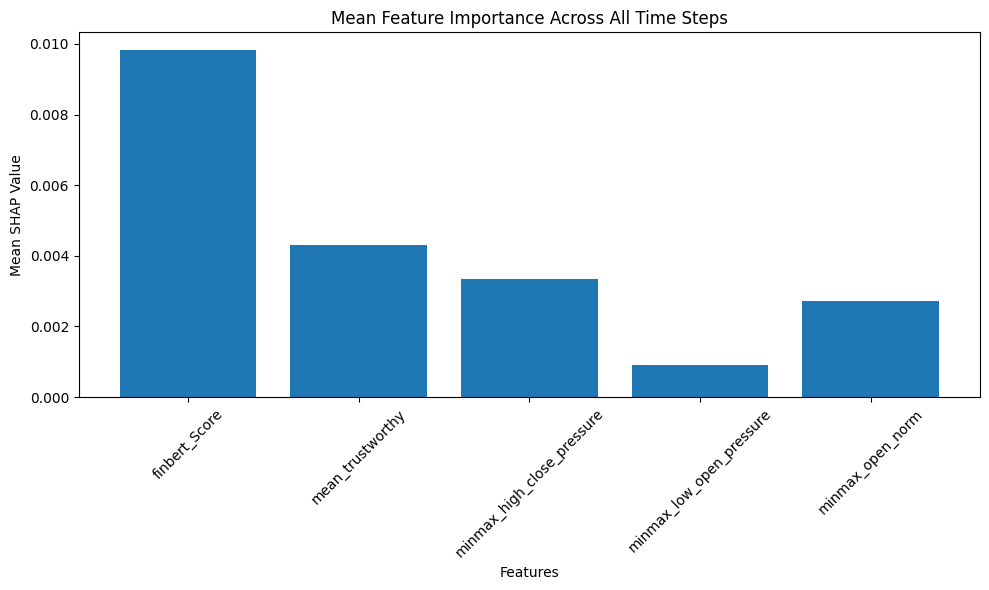

61


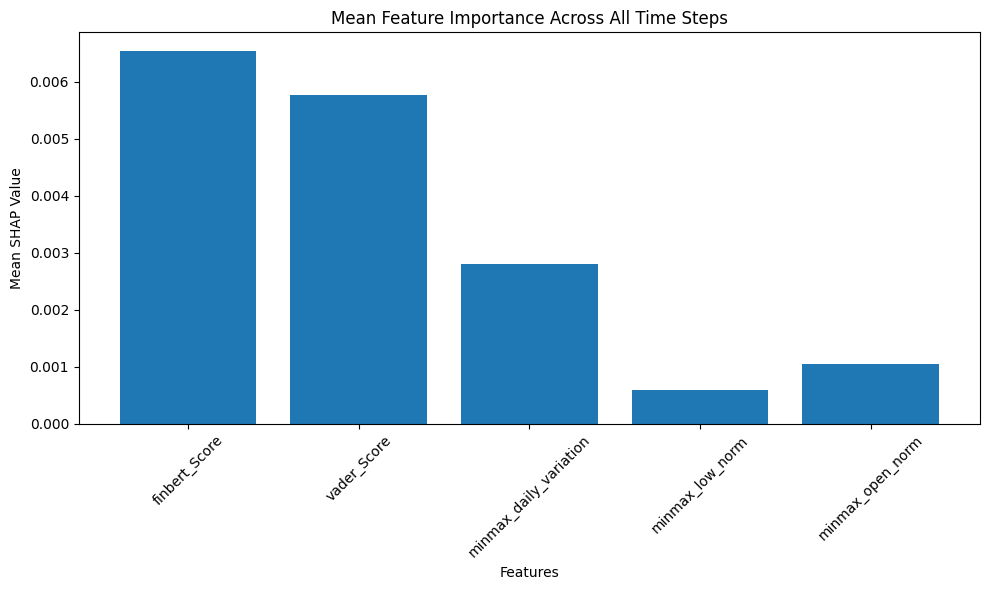

In [46]:
# Średnia z okien czasowych
for index, row in top_10_df.iterrows():
    print(index)
    shap_values = row['aggregated_shap']
    feature_names = row['cols_used']
    plot_mean_feature_importance(shap_values, feature_names)

### Przykładowy model

In [ ]:
window_size = 10
target_cols = ['target_5']
cols_used = {'bart_Score',
 'norm_rsi_14',
 'log_return_5',
 'minmax_low_open_pressure',
 'minmax_open_norm'}
X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)

model, history = make_model_better(X, y, X_val, y_val, n_epochs=200, lstm_units=32,
                              dense_units=8, patience=100)

#### Wyniki

In [48]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)

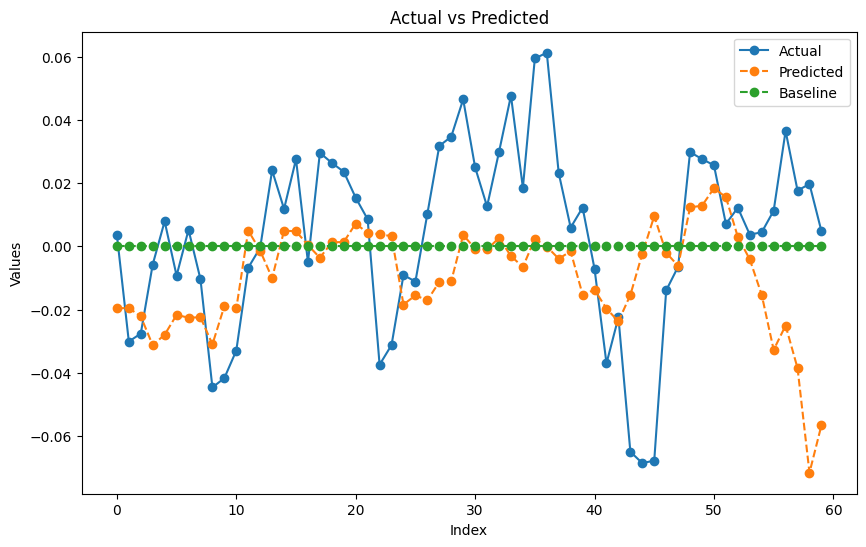

In [49]:
k=-60
plot_actual_vs_predicted(y[k:], y_pred_train[k:], y_base0_train[k:])

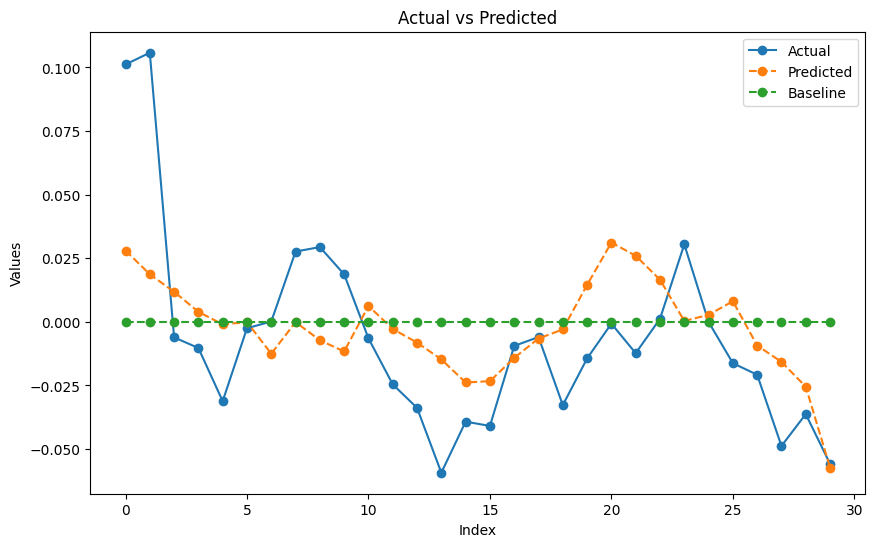

In [50]:
plot_actual_vs_predicted(y_val, y_pred_val, y_base0_val)

In [51]:
print('Model')
print(calculate_metrics(y, y_pred_train, np.array([1]), np.array([1]), y_val, y_pred_val))
print('-----')
print('Baseline 0')
print(calculate_metrics(y, y_base0_train, np.array([1]), np.array([1]), y_val, y_base0_val))
print('-----')
print('Baseline Prev')
print(calculate_metrics(y, y_base_train, np.array([1]), np.array([1]), y_val, y_base_val))


Model
                 MAE       MSE      RMSE  R2 Score         MAPE      MASE
Train       0.033652  0.001944  0.044089  0.318572   295.632777  1.291433
Test        0.000000  0.000000  0.000000       NaN     0.000000  0.000000
Validation  0.024451  0.000957  0.030931  0.313142  1584.531329  0.938321
-----
Baseline 0
                 MAE       MSE      RMSE  R2 Score   MAPE      MASE
Train       0.039650  0.002853  0.053411 -0.000031  100.0  1.521588
Test        0.000000  0.000000  0.000000       NaN    0.0  0.000000
Validation  0.027415  0.001435  0.037876 -0.029927  100.0  1.052056
-----
Baseline Prev
                 MAE       MSE      RMSE  R2 Score         MAPE      MASE
Train       0.058321  0.005983  0.077351 -1.097411   552.156845  2.238101
Test        0.000000  0.000000  0.000000       NaN     0.000000  0.000000
Validation  0.052187  0.004144  0.064371 -1.974836  4423.503320  2.002708


In [52]:
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X_val)

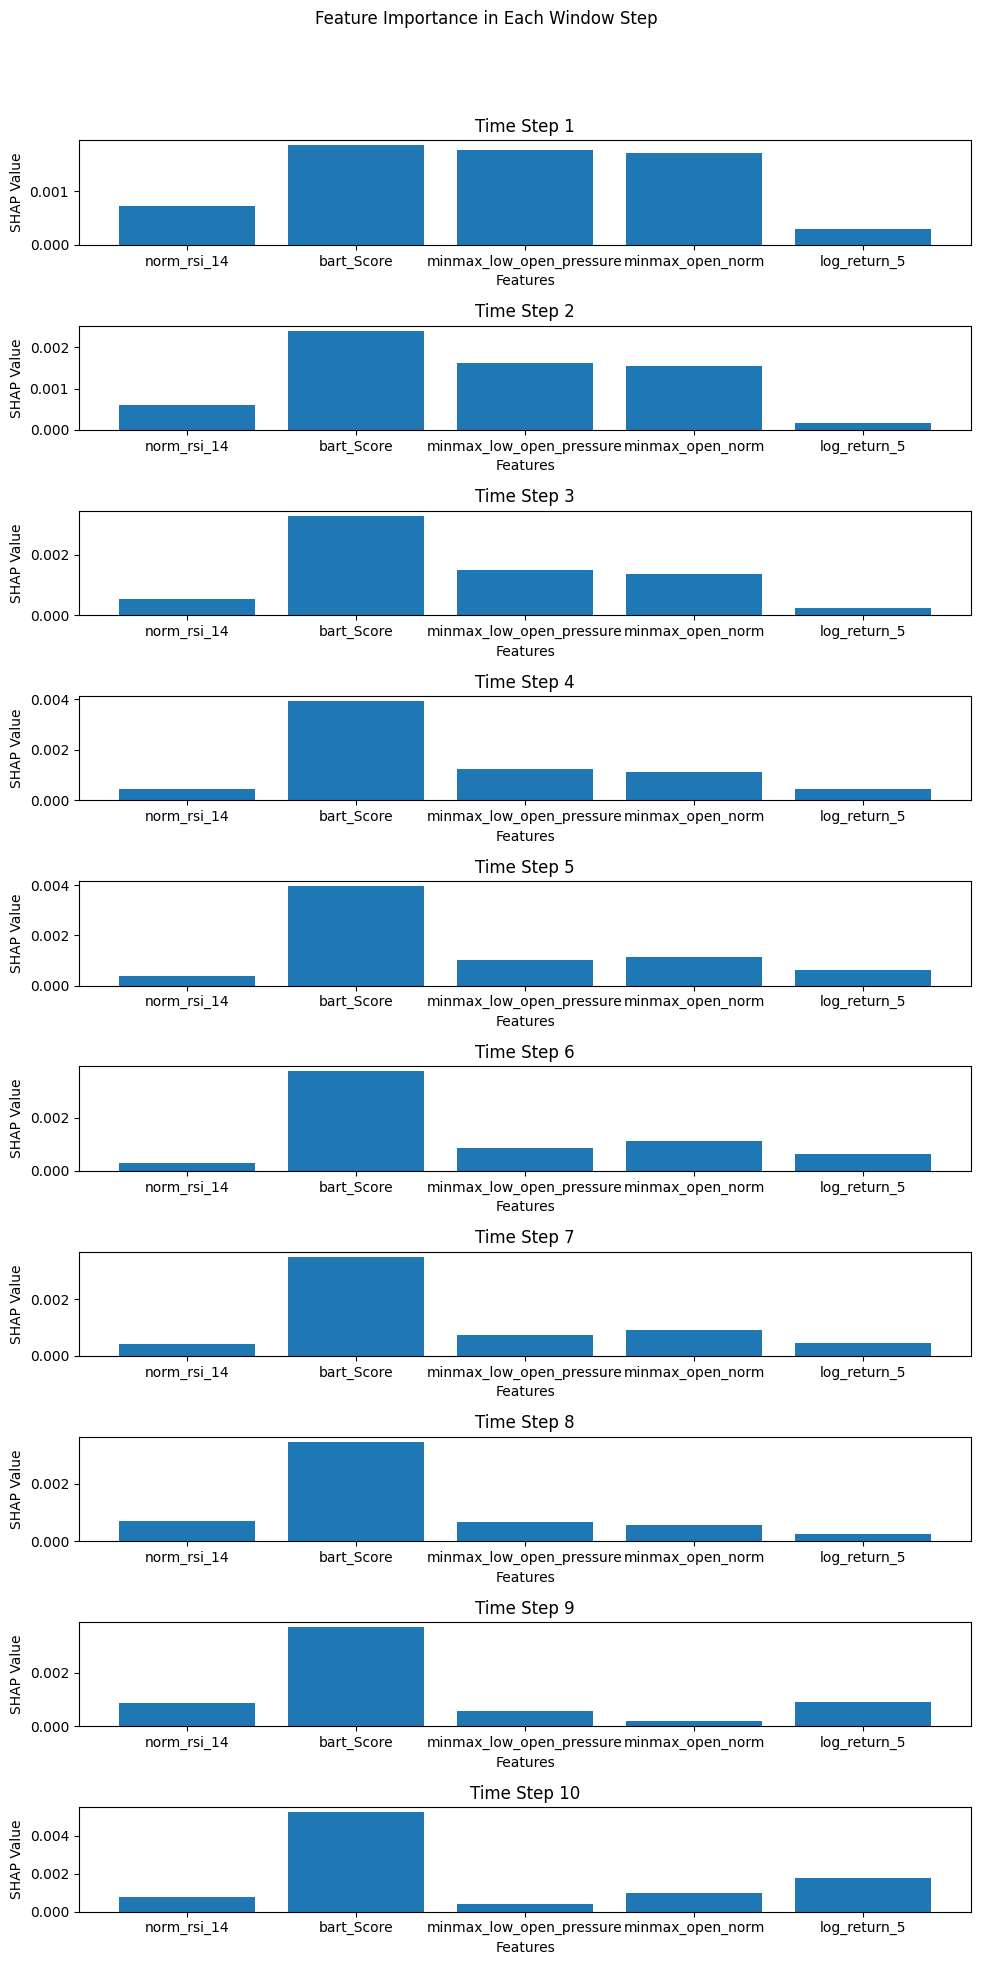

In [53]:
feature_names = list(cols_used)
plot_feature_importance(shap_values, feature_names,window_size)